# ENGY 604 Part A: Pyomo Formulation
The Pyomo optimization problem solution for Part A

In [ ]:
# Optional Google Colab Setup - Install GLPK and Pyomo
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab environment")
    print("Installing required packages...")

    # Install GLPK solver
    !apt-get install -y -qq glpk-utils

    # Install Pyomo
    !pip install -q pyomo

    print("✓ GLPK solver installed successfully")
    print("✓ Pyomo installed successfully")
    print("\nYou can now run the rest of the notebook!")

except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab - skipping installation")
    print("Assuming local environment with GLPK already installed")

Not running in Google Colab - skipping installation
Assuming local environment with GLPK already installed


## Section 1 – Setup

In [ ]:
from pathlib import Path

import pandas as pd

from pyomo.environ import (
    Binary,
    ConcreteModel,
    Constraint,
    NonNegativeReals,
    Objective,
    Param,
    Set,
    SolverFactory,
    Var,
    minimize,
    value,
)

# Planning horizon and unit conversions
H = 20
CF1 = 31.54
CF2 = 1e-6
# CF2 = 1

# Resource data from Table 3
resource_data = {
    "Natural Gas": {"price_per_GJ": 8.89, "emissions_per_PJ": 56.0},
    "Biomass": {"price_per_GJ": 9.72, "emissions_per_PJ": 100.0},
    "Grid Electricity": {"price_per_GJ": 36.11, "emissions_per_PJ": 90.0},
}

# Generator data from Table 2
generator_data = {
    "BioST": {
        "capex": 250.0,
        "opex": 15.0,
        "eta_elec": 0.68,
        "eta_heat": 0.0,
        "capacity_min": 100.0,
        "capacity_max": 1e6,
    },
    "CHP": {
        "capex": 500.0,
        "opex": 15.0,
        "eta_elec": 0.44,
        "eta_heat": 0.28,
        "capacity_min": 800.0,
        "capacity_max": 1e6,
    },
    "SolarPV": {
        "capex": 2000.0,
        "opex": 500.0,
        "eta_elec": 0.09,
        "eta_heat": 0.0,
        "capacity_min": 10.0,
        "capacity_max": 300.0,
    },
    "Wind": {
        "capex": 2000.0,
        "opex": 1200.0,
        "eta_elec": 0.22,
        "eta_heat": 0.0,
        "capacity_min": 10.0,
        "capacity_max": 500.0,
    },
}

# Conversion device data from Table 1 and Table 4
converter_data = {
    "Refrigerator": {"demand_kw": 1000.0, "eta": 3.0, "capex": 70.0, "opex": 4.0},
    "LED": {"demand_kw": 200.0, "eta": 0.80, "capex": 10.0, "opex": 1.0},
    "Heater": {"demand_kw": 100.0, "eta": 0.85, "capex": 30.0, "opex": 3.0},
}

# Sets for later reference
resources = list(resource_data.keys())
generators = list(generator_data.keys())
converters = list(converter_data.keys())

# Mapping between generators and their primary resources
fuel_links = {
    "BioST": "Biomass",
    "CHP": "Natural Gas",
}

grid_resource = "Grid Electricity"
chp_generator = "CHP"

objectives = ["cost", "emissions", "efficiency"]
objectives_units = ["$", "kg", "kW"]

solver_name = "glpk"

# Configure solver based on environment
if IN_COLAB:
    # Google Colab - GLPK is installed via apt-get and available in PATH
    print("Configuring solver for Google Colab environment...")
    solver = SolverFactory(solver_name)
    print("✓ Using system GLPK solver")
else:
    # Local environment - Check for Windows executable first
    print("Configuring solver for local environment...")

    # Try Windows-specific path first
    windows_executable = Path(r"C:\glpk-4.65\w64\glpsol.exe")

    if windows_executable.exists():
        solver = SolverFactory(solver_name, executable=str(windows_executable))
        print(f"✓ Using GLPK from: {windows_executable}")
    else:
        # Try system PATH (Linux/Mac or Windows with GLPK in PATH)
        solver = SolverFactory(solver_name)
        print("✓ Using GLPK from system PATH")

# Verify solver is available
if not solver.available(exception_flag=False):
    print("\n" + "="*70)
    print("ERROR: GLPK solver is not available!")
    print("="*70)
    if IN_COLAB:
        print("Run the installation cell above (Section 0) first.")
    else:
        print("Please install GLPK:")
        print("  • Windows: Download from https://www.gnu.org/software/glpk/")
        print("  • Linux: sudo apt-get install glpk-utils")
        print("  • Mac: brew install glpk")
    print("="*70)
    raise RuntimeError("GLPK solver is not available.")
else:
    print(f"✓ Solver '{solver_name}' is ready to use\n")

Configuring solver for local environment...
✓ Using GLPK from: C:\glpk-4.65\w64\glpsol.exe
✓ Solver 'glpk' is ready to use



## Section 2 – Intermediate Parameter Calculations
Recreate the conversions from Appendix B so the Pyomo model can consume consistent numeric inputs.

In [ ]:
# Intermediate parameter calculations
resource_price_kwyr = {r: vals["price_per_GJ"] * CF1 for r, vals in resource_data.items()}
resource_emissions_kwyr = {r: vals["emissions_per_PJ"] * CF1 * CF2 for r, vals in resource_data.items()}

converter_input_capacity = {
    d: converter_data[d]["demand_kw"] / converter_data[d]["eta"] for d in converters
}

elec_demand_total = sum(
    converter_input_capacity[d] for d in ("Refrigerator", "LED")
)
heat_demand_total = converter_input_capacity["Heater"]

fixed_converter_cost = sum(
    converter_data[d]["demand_kw"] * converter_data[d]["capex"]
    + H * converter_input_capacity[d] * converter_data[d]["opex"]
    for d in converters
)

print("Electrical demand (kW):", round(elec_demand_total, 4))
print("Heat demand (kW):", round(heat_demand_total, 4))
print("Resource prices ($/kW-year):")
for r, val in resource_price_kwyr.items():
    print(f"  {r}: {val:.4f}")
print("Resource emissions (kg/kW-year):")
for r, val in resource_emissions_kwyr.items():
    print(f"  {r}: {val:.6e}")
print("Converter input capacities (kW):")
for d, val in converter_input_capacity.items():
    print(f"  {d}: {val:.4f}")
print(f"Fixed converter cost ($): {fixed_converter_cost:,.2f}")

Electrical demand (kW): 583.3333
Heat demand (kW): 117.6471
Resource prices ($/kW-year):
  Natural Gas: 280.3906
  Biomass: 306.5688
  Grid Electricity: 1138.9094
Resource emissions (kg/kW-year):
  Natural Gas: 1.766240e-03
  Biomass: 3.154000e-03
  Grid Electricity: 2.838600e-03
Converter input capacities (kW):
  Refrigerator: 333.3333
  LED: 250.0000
  Heater: 117.6471
Fixed converter cost ($): 113,725.49


## Section 3 – Pyomo Model Construction
Build a reusable function that instantiates the MILP with the constraints and objectives from Section 4 of the formulation.

In [ ]:
def build_model(objective_name: str = "cost"):
    """Create a fresh Pyomo model for the requested objective."""
    objective_key = objective_name.lower()
    if objective_key not in objectives:
        raise ValueError("objective_name must be 'cost', 'emissions', or 'input'")

    model = ConcreteModel(name=f"PartA_{objective_key}")

    # -------------------------
    # Base Parameters
    # -------------------------
    model.G = Set(initialize=generators, ordered=True)
    model.R = Set(initialize=resources, ordered=True)
    model.H = Param(initialize=H)
    model.capex = Param(model.G, initialize={g: generator_data[g]["capex"] for g in generators})
    model.opex = Param(model.G, initialize={g: generator_data[g]["opex"] for g in generators})
    model.eta_elec = Param(model.G, initialize={g: generator_data[g]["eta_elec"] for g in generators})
    model.eta_heat = Param(model.G, initialize={g: generator_data[g]["eta_heat"] for g in generators})
    model.capacity_min = Param(model.G, initialize={g: generator_data[g]["capacity_min"] for g in generators})
    model.capacity_max = Param(model.G, initialize={g: generator_data[g]["capacity_max"] for g in generators})

    # -------------------------
    # Intermediate Parameters
    # -------------------------
    model.price_kwyr = Param(model.R, initialize=resource_price_kwyr)
    model.emissions_kwyr = Param(model.R, initialize=resource_emissions_kwyr)
    model.electric_demand = Param(initialize=elec_demand_total)
    model.heat_demand = Param(initialize=heat_demand_total)
    model.converter_cost = Param(initialize=fixed_converter_cost)

    # -------------------------
    # Decision Variables
    # -------------------------
    model.C = Var(model.G, domain=NonNegativeReals)
    model.P_elec = Var(model.G, domain=NonNegativeReals)
    model.P_cons = Var(model.R, domain=NonNegativeReals)
    model.y = Var(model.G, domain=Binary)

    # -------------------------
    # Constraints
    # -------------------------
    def electricity_balance_rule(m):
        return sum(m.P_elec[g] for g in m.G) + m.P_cons[grid_resource] == m.electric_demand

    model.electricity_balance = Constraint(rule=electricity_balance_rule)

    def heat_balance_rule(m):
        return m.P_elec[chp_generator] * (m.eta_heat[chp_generator] / m.eta_elec[chp_generator]) == m.heat_demand

    model.heat_balance = Constraint(rule=heat_balance_rule)

    def fuel_balance_rule(m, g):
        resource = fuel_links.get(g)
        if resource is None:
            return Constraint.Skip
        return m.P_elec[g] == m.P_cons[resource] * m.eta_elec[g]

    model.fuel_balance = Constraint(model.G, rule=fuel_balance_rule)

    def output_limit_rule(m, g):
        return m.P_elec[g] <= m.C[g]

    model.output_limit = Constraint(model.G, rule=output_limit_rule)

    def capacity_lower_rule(m, g):
        return m.y[g] * m.capacity_min[g] <= m.C[g]

    model.capacity_lower = Constraint(model.G, rule=capacity_lower_rule)

    def capacity_upper_rule(m, g):
        return m.C[g] <= m.y[g] * m.capacity_max[g]

    model.capacity_upper = Constraint(model.G, rule=capacity_upper_rule)

    model.integer_cut = Constraint(expr=sum(model.y[g] for g in model.G) <= 1)

    if objective_key == "cost":
        expr = (
            sum(model.C[g] * model.capex[g] for g in model.G)
            + model.H * sum(model.C[g] * model.opex[g] for g in model.G)
            + model.H * sum(model.P_cons[r] * model.price_kwyr[r] for r in model.R)
            + model.converter_cost
        )
    elif objective_key == "emissions":
        expr = model.H * sum(model.P_cons[r] * model.emissions_kwyr[r] for r in model.R)
    elif objective_key == "efficiency":
        expr = sum(model.P_cons[r] for r in model.R)
    else:
        raise ValueError("Invalid objective key")

    model.obj = Objective(expr=expr, sense=minimize)
    return model

## Section 4 – Solve for Objectives (Independent)
Solve the MILP three times independently (cost, emissions, and primary input) and summarize the key decisions.

In [ ]:
solution_summary = {}
for objective_name in objectives:
    model = build_model(objective_name)
    results = solver.solve(model, tee=False)

    # Calculate emissions breakdown by resource
    emissions_by_resource = {
        r: float(value(model.P_cons[r])) * resource_emissions_kwyr[r] * H
        for r in resources
    }
    total_emissions = sum(emissions_by_resource.values())

    solution_summary[objective_name] = {
        "status": str(results.solver.status),
        "termination": str(results.solver.termination_condition),
        "objective": float(value(model.obj)),
        "build": {g: int(round(value(model.y[g]))) for g in generators},
        "capacity": {g: float(value(model.C[g])) for g in generators},
        "generation": {g: float(value(model.P_elec[g])) for g in generators},
        "resources": {r: float(value(model.P_cons[r])) for r in resources},
        "emissions_by_resource": emissions_by_resource,
        "total_emissions": total_emissions,
    }

for objective_name, summary in solution_summary.items():
    print(f"=== Objective: {objective_name.upper()} ===")
    print(f"Status: {summary['status']} | Termination: {summary['termination']}")
    obj_val = summary['objective']
    unit = objectives_units[objectives.index(objective_name)]
    if objective_name == "cost":
        # comma separators and two decimal places for cost
        print(f"Objective value: {obj_val:,.2f} {unit}")
    else:
        # two decimal places for other objectives
        print(f"Objective value: {obj_val:.2f} {unit}")
    print("\nBuild decisions and operating levels:")
    for g in generators:
        print(
            f"  {g}: y={summary['build'][g]}, C={summary['capacity'][g]:.2f} kW, P={summary['generation'][g]:.2f} kW"
        )
    print("\nResource consumption (kW):")
    for r in resources:
        print(f"  {r}: {summary['resources'][r]:.2f}")
    print(f"\nTotal Emissions: {summary['total_emissions']:.2f} kg")
    print("Emissions breakdown by resource:")
    for r in resources:
        emissions_val = summary['emissions_by_resource'][r]
        percentage = (emissions_val / summary['total_emissions'] * 100) if summary['total_emissions'] > 0 else 0
        print(f"  {r}: {emissions_val:.2f} kg ({percentage:.1f}%)")
    print()

=== Objective: COST ===
Status: ok | Termination: optimal
Objective value: 12,186,131.77 $

Build decisions and operating levels:
  BioST: y=0, C=0.00 kW, P=0.00 kW
  CHP: y=1, C=800.00 kW, P=184.87 kW
  SolarPV: y=0, C=0.00 kW, P=0.00 kW
  Wind: y=0, C=0.00 kW, P=0.00 kW

Resource consumption (kW):
  Natural Gas: 420.17
  Biomass: 0.00
  Grid Electricity: 398.46

Total Emissions: 37.46 kg
Emissions breakdown by resource:
  Natural Gas: 14.84 kg (39.6%)
  Biomass: 0.00 kg (0.0%)
  Grid Electricity: 22.62 kg (60.4%)

=== Objective: EMISSIONS ===
Status: ok | Termination: optimal
Objective value: 37.46 kg

Build decisions and operating levels:
  BioST: y=0, C=0.00 kW, P=0.00 kW
  CHP: y=1, C=800.00 kW, P=184.87 kW
  SolarPV: y=0, C=0.00 kW, P=0.00 kW
  Wind: y=0, C=0.00 kW, P=0.00 kW

Resource consumption (kW):
  Natural Gas: 420.17
  Biomass: 0.00
  Grid Electricity: 398.46

Total Emissions: 37.46 kg
Emissions breakdown by resource:
  Natural Gas: 14.84 kg (39.6%)
  Biomass: 0.00 kg (0.

## Section 5 – Multi-Objective Optimization
Now we solve the problem using multi-objective optimization techniques to balance all three objectives simultaneously.

### Epsilon Constraint Method
Optimize one objective while constraining the others to be within epsilon of their optimal values.

In [ ]:
def build_epsilon_constraint_model(primary_objective="cost"):
    """
    Create a multi-objective model using epsilon constraint method with mutable parameters.
    This allows efficient iteration without rebuilding the model.

    Parameters:
    -----------
    primary_objective : str
        The objective to optimize ('cost', 'emissions', or 'efficiency')
    """
    model = ConcreteModel(name=f"PartA_epsilon_{primary_objective}")

    # -------------------------
    # Base Parameters
    # -------------------------
    model.G = Set(initialize=generators, ordered=True)
    model.R = Set(initialize=resources, ordered=True)
    model.H = Param(initialize=H)
    model.capex = Param(model.G, initialize={g: generator_data[g]["capex"] for g in generators})
    model.opex = Param(model.G, initialize={g: generator_data[g]["opex"] for g in generators})
    model.eta_elec = Param(model.G, initialize={g: generator_data[g]["eta_elec"] for g in generators})
    model.eta_heat = Param(model.G, initialize={g: generator_data[g]["eta_heat"] for g in generators})
    model.capacity_min = Param(model.G, initialize={g: generator_data[g]["capacity_min"] for g in generators})
    model.capacity_max = Param(model.G, initialize={g: generator_data[g]["capacity_max"] for g in generators})

    # -------------------------
    # Intermediate Parameters
    # -------------------------
    model.price_kwyr = Param(model.R, initialize=resource_price_kwyr)
    model.emissions_kwyr = Param(model.R, initialize=resource_emissions_kwyr)
    model.electric_demand = Param(initialize=elec_demand_total)
    model.heat_demand = Param(initialize=heat_demand_total)
    model.converter_cost = Param(initialize=fixed_converter_cost)

    # -------------------------
    # Mutable Epsilon Parameters
    # -------------------------
    # Initialize with large values (effectively no constraint)
    model.epsilon_emissions = Param(initialize=1e10, mutable=True)
    model.epsilon_efficiency = Param(initialize=1e10, mutable=True)

    # -------------------------
    # Decision Variables
    # -------------------------
    model.C = Var(model.G, domain=NonNegativeReals)
    model.P_elec = Var(model.G, domain=NonNegativeReals)
    model.P_cons = Var(model.R, domain=NonNegativeReals)
    model.y = Var(model.G, domain=Binary)

    # -------------------------
    # Constraints
    # -------------------------
    def electricity_balance_rule(m):
        return sum(m.P_elec[g] for g in m.G) + m.P_cons[grid_resource] == m.electric_demand

    model.electricity_balance = Constraint(rule=electricity_balance_rule)

    def heat_balance_rule(m):
        return m.P_elec[chp_generator] * (m.eta_heat[chp_generator] / m.eta_elec[chp_generator]) == m.heat_demand

    model.heat_balance = Constraint(rule=heat_balance_rule)

    def fuel_balance_rule(m, g):
        resource = fuel_links.get(g)
        if resource is None:
            return Constraint.Skip
        return m.P_elec[g] == m.P_cons[resource] * m.eta_elec[g]

    model.fuel_balance = Constraint(model.G, rule=fuel_balance_rule)

    def output_limit_rule(m, g):
        return m.P_elec[g] <= m.C[g]

    model.output_limit = Constraint(model.G, rule=output_limit_rule)

    def capacity_lower_rule(m, g):
        return m.y[g] * m.capacity_min[g] <= m.C[g]

    model.capacity_lower = Constraint(model.G, rule=capacity_lower_rule)

    def capacity_upper_rule(m, g):
        return m.C[g] <= m.y[g] * m.capacity_max[g]

    model.capacity_upper = Constraint(model.G, rule=capacity_upper_rule)

    model.integer_cut = Constraint(expr=sum(model.y[g] for g in model.G) <= 1)

    # -------------------------
    # Define all three objective expressions
    # -------------------------
    model.cost_expr = (
        sum(model.C[g] * model.capex[g] for g in model.G)
        + model.H * sum(model.C[g] * model.opex[g] for g in model.G)
        + model.H * sum(model.P_cons[r] * model.price_kwyr[r] for r in model.R)
        + model.converter_cost
    )
    model.emissions_expr = model.H * sum(model.P_cons[r] * model.emissions_kwyr[r] for r in model.R)
    model.efficiency_expr = sum(model.P_cons[r] for r in model.R)

    # -------------------------
    # Epsilon Constraints (using mutable parameters)
    # -------------------------
    def emissions_epsilon_rule(m):
        return m.emissions_expr <= m.epsilon_emissions

    def efficiency_epsilon_rule(m):
        return m.efficiency_expr <= m.epsilon_efficiency

    model.emissions_epsilon_constraint = Constraint(rule=emissions_epsilon_rule)
    model.efficiency_epsilon_constraint = Constraint(rule=efficiency_epsilon_rule)

    # -------------------------
    # Primary Objective
    # -------------------------
    objective_map = {
        "cost": model.cost_expr,
        "emissions": model.emissions_expr,
        "efficiency": model.efficiency_expr,
    }

    model.obj = Objective(expr=objective_map[primary_objective], sense=minimize)

    return model

In [ ]:
# Build the epsilon constraint model once
print("=== Improved Epsilon Constraint Method ===")
print("Primary objective: Minimize COST")
print("Using mutable parameters for efficient re-solving\n")

ec_model = build_epsilon_constraint_model(primary_objective="cost")

# Set epsilon values (can be changed without rebuilding the model)
ec_model.epsilon_emissions.value = 1.10 * solution_summary["emissions"]["objective"]
ec_model.epsilon_efficiency.value = 1.10 * solution_summary["efficiency"]["objective"]

# Solve
ec_results_improved = solver.solve(ec_model, tee=False)

print(f"Status: {ec_results_improved.solver.status} | Termination: {ec_results_improved.solver.termination_condition}")
print(f"\nIndividual Objective Values:")
print(f"  Cost (PRIMARY): ${value(ec_model.cost_expr):,.2f}")
print(f"  Emissions: {value(ec_model.emissions_expr):.2f} kg (limit: {ec_model.epsilon_emissions.value:.2f} kg)")
print(f"  Efficiency (Primary Input): {value(ec_model.efficiency_expr):.2f} kW (limit: {ec_model.epsilon_efficiency.value:.2f} kW)")
print(f"\nBuild decisions and operating levels:")
for g in generators:
    print(f"  {g}: y={int(round(value(ec_model.y[g])))}, C={value(ec_model.C[g]):.2f} kW, P={value(ec_model.P_elec[g]):.2f} kW")
print(f"\nResource consumption (kW):")
for r in resources:
    print(f"  {r}: {value(ec_model.P_cons[r]):.2f}")
print()

=== Improved Epsilon Constraint Method ===
Primary objective: Minimize COST
Using mutable parameters for efficient re-solving

Status: ok | Termination: optimal

Individual Objective Values:
  Cost (PRIMARY): $12,186,131.77
  Emissions: 37.46 kg (limit: 41.21 kg)
  Efficiency (Primary Input): 818.63 kW (limit: 900.49 kW)

Build decisions and operating levels:
  BioST: y=0, C=0.00 kW, P=0.00 kW
  CHP: y=1, C=800.00 kW, P=184.87 kW
  SolarPV: y=0, C=0.00 kW, P=0.00 kW
  Wind: y=0, C=0.00 kW, P=0.00 kW

Resource consumption (kW):
  Natural Gas: 420.17
  Biomass: 0.00
  Grid Electricity: 398.46



In [ ]:
# Example: Explore Pareto frontier by varying epsilon values
print("=== Exploring Pareto Frontier ===")
print("Varying emissions constraint from 100% to 200% of optimal\n")

pareto_results = []
# epsilon_factors = [1.0, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.40, 1.50]
epsilon_factors_two = [1.0, 1.10, 1.20, 1.30, 1.40, 1.50, 1.60, 1.70, 1.80, 1.90, 2.0]

for factor in epsilon_factors_two:
    # Update epsilon values without rebuilding model
    ec_model.epsilon_emissions.value = factor * solution_summary["emissions"]["objective"]
    ec_model.epsilon_efficiency.value = 1.50 * solution_summary["efficiency"]["objective"]  # Keep efficiency relaxed

    # Re-solve with new epsilon values
    results = solver.solve(ec_model, tee=False)

    if results.solver.termination_condition == 'optimal':
        pareto_results.append({
            'epsilon_factor': factor,
            'cost': value(ec_model.cost_expr),
            'emissions': value(ec_model.emissions_expr),
            'efficiency': value(ec_model.efficiency_expr),
            'emissions_limit': ec_model.epsilon_emissions.value,
            'generator': [g for g in generators if int(round(value(ec_model.y[g]))) == 1][0] if any(int(round(value(ec_model.y[g]))) for g in generators) else "None"
        })

# Display Pareto frontier results
pareto_df = pd.DataFrame(pareto_results)
pareto_df['epsilon_pct'] = pareto_df['epsilon_factor'] * 100
pareto_df = pareto_df[['epsilon_pct', 'cost', 'emissions', 'emissions_limit', 'efficiency', 'generator']]
pareto_df.columns = ['Emissions Limit (%)', 'Cost ($)', 'Emissions (kg)', 'Max Emissions (kg)', 'Primary Input (kW)', 'Generator']

print(pareto_df.to_string(index=False))
print("\nNote: Emissions Limit (%) shows the percentage of optimal emissions allowed")

=== Exploring Pareto Frontier ===
Varying emissions constraint from 100% to 200% of optimal

 Emissions Limit (%)     Cost ($)  Emissions (kg)  Max Emissions (kg)  Primary Input (kW) Generator
               100.0 1.218613e+07       37.463689           37.463689          818.627451       CHP
               110.0 1.218613e+07       37.463689           41.210058          818.627451       CHP
               120.0 1.218613e+07       37.463689           44.956427          818.627451       CHP
               130.0 1.218613e+07       37.463689           48.702796          818.627451       CHP
               140.0 1.218613e+07       37.463689           52.449165          818.627451       CHP
               150.0 1.218613e+07       37.463689           56.195534          818.627451       CHP
               160.0 1.218613e+07       37.463689           59.941903          818.627451       CHP
               170.0 1.218613e+07       37.463689           63.688271          818.627451       CHP
       

## Section 6 – Visualization of Results
Create visual representations of the optimal solutions and Pareto frontier.

### 6.1 Individual Objective Solutions Comparison

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Import matplotlib if not already available
print("Matplotlib imported successfully!")

Matplotlib imported successfully!


C:\Users\matte\AppData\Local\Temp\ipykernel_53660\1020826659.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['Min Cost', 'Min Emissions', 'Min Input'])


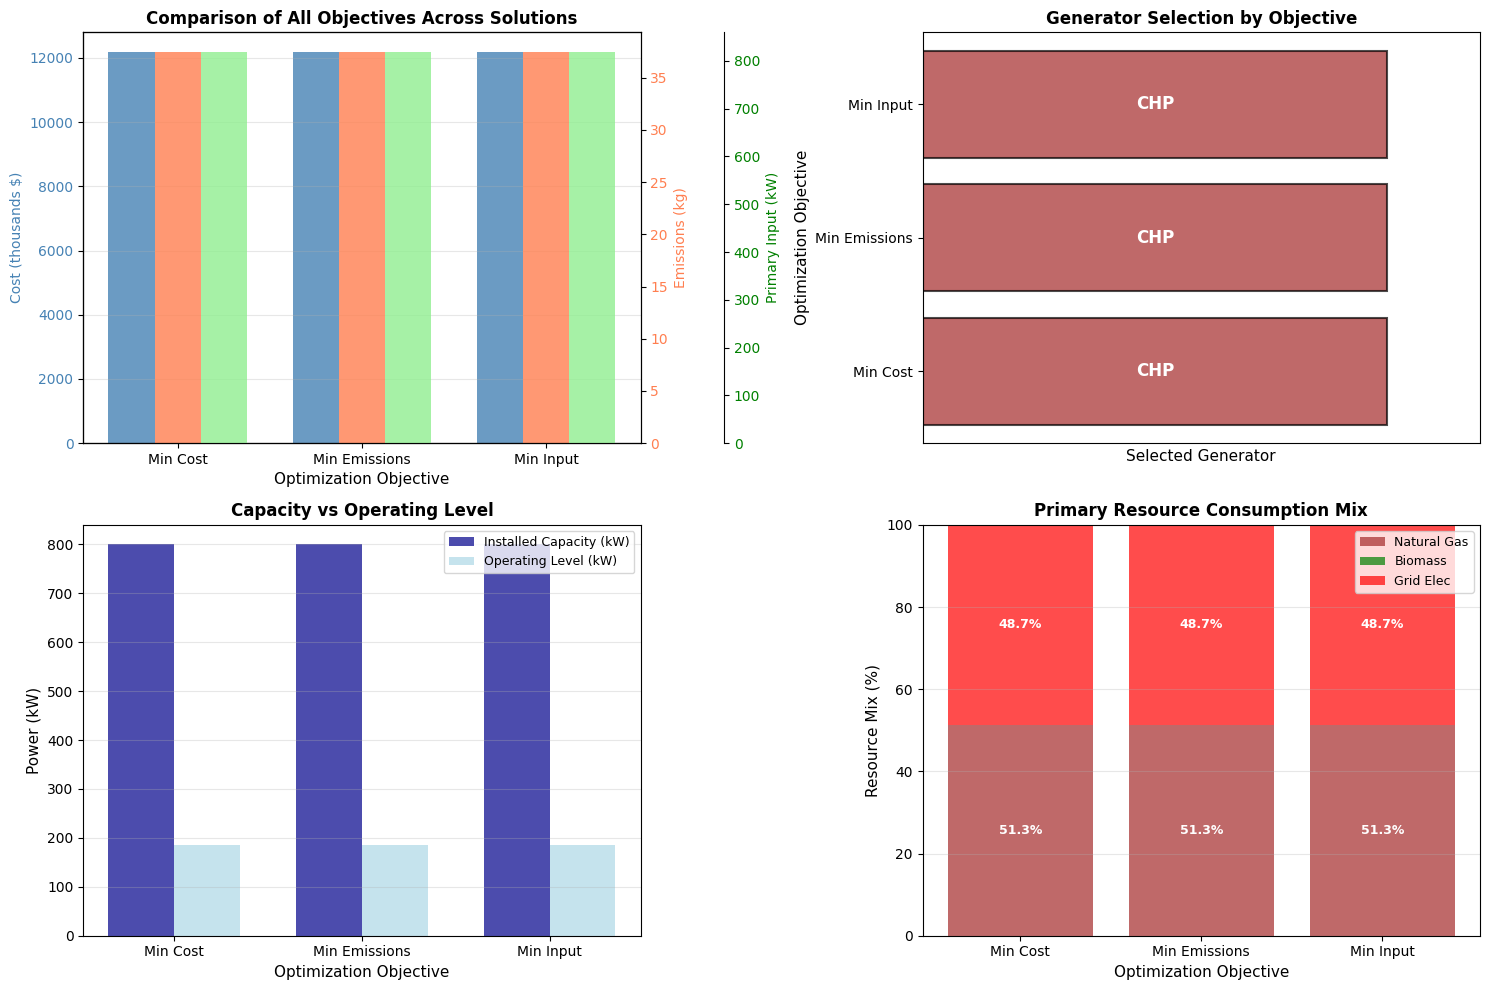


Individual objective solutions visualization complete!


In [ ]:
# Create a comprehensive comparison of the three objective solutions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Calculate all three objective values for each solution
obj_values = {}
for obj_name in objectives:
    # Get the model solution
    model = build_model(obj_name)
    solver.solve(model, tee=False)

    # Calculate all three objective values
    cost_val = value(
        sum(model.C[g] * model.capex[g] for g in generators)
        + model.H * sum(model.C[g] * model.opex[g] for g in generators)
        + model.H * sum(model.P_cons[r] * model.price_kwyr[r] for r in resources)
        + model.converter_cost
    )
    emissions_val = value(model.H * sum(model.P_cons[r] * model.emissions_kwyr[r] for r in resources))
    efficiency_val = value(sum(model.P_cons[r] for r in resources))

    obj_values[obj_name] = {
        'cost': cost_val,
        'emissions': emissions_val,
        'efficiency': efficiency_val,
        'generator': [g for g in generators if int(round(value(model.y[g]))) == 1][0] if any(int(round(value(model.y[g]))) for g in generators) else "None"
    }

# Plot 1: Bar chart comparing objective values across solutions
ax1 = axes[0, 0]
x_pos = np.arange(len(objectives))
width = 0.25

costs_normalized = [obj_values[obj]['cost'] / 1000 for obj in objectives]  # in thousands
emissions_normalized = [obj_values[obj]['emissions'] for obj in objectives]
efficiency_normalized = [obj_values[obj]['efficiency'] for obj in objectives]

ax1_twin1 = ax1.twinx()
ax1_twin2 = ax1.twinx()
ax1_twin2.spines['right'].set_position(('outward', 60))

p1 = ax1.bar(x_pos - width, costs_normalized, width, label='Cost (k$)', color='steelblue', alpha=0.8)
p2 = ax1_twin1.bar(x_pos, emissions_normalized, width, label='Emissions (kg)', color='coral', alpha=0.8)
p3 = ax1_twin2.bar(x_pos + width, efficiency_normalized, width, label='Primary Input (kW)', color='lightgreen', alpha=0.8)

ax1.set_xlabel('Optimization Objective', fontsize=11)
ax1.set_ylabel('Cost (thousands $)', color='steelblue', fontsize=10)
ax1_twin1.set_ylabel('Emissions (kg)', color='coral', fontsize=10)
ax1_twin2.set_ylabel('Primary Input (kW)', color='green', fontsize=10)
ax1.set_title('Comparison of All Objectives Across Solutions', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Min Cost', 'Min Emissions', 'Min Input'])
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1_twin1.tick_params(axis='y', labelcolor='coral')
ax1_twin2.tick_params(axis='y', labelcolor='green')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Generator Selection by Objective
ax2 = axes[0, 1]
generator_selected = [obj_values[obj]['generator'] for obj in objectives]
colors_map = {'CHP': 'brown', 'BioST': 'green', 'SolarPV': 'orange', 'Wind': 'skyblue', 'None': 'gray'}
colors = [colors_map.get(g, 'gray') for g in generator_selected]

ax2.barh(objectives, [1]*len(objectives), color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Selected Generator', fontsize=11)
ax2.set_ylabel('Optimization Objective', fontsize=11)
ax2.set_title('Generator Selection by Objective', fontsize=12, fontweight='bold')
ax2.set_yticklabels(['Min Cost', 'Min Emissions', 'Min Input'])
ax2.set_xlim(0, 1.2)
ax2.set_xticks([])

# Add generator names on bars
for i, (obj, gen) in enumerate(zip(objectives, generator_selected)):
    ax2.text(0.5, i, gen, ha='center', va='center', fontsize=12, fontweight='bold', color='white')

# Plot 3: Capacity and Generation by Objective
ax3 = axes[1, 0]
x_pos = np.arange(len(objectives))
width = 0.35

capacities = [solution_summary[obj]['capacity']['CHP'] if solution_summary[obj]['build']['CHP'] == 1
              else max([solution_summary[obj]['capacity'][g] for g in generators if solution_summary[obj]['build'][g] == 1], default=0)
              for obj in objectives]
generations = [solution_summary[obj]['generation']['CHP'] if solution_summary[obj]['build']['CHP'] == 1
               else max([solution_summary[obj]['generation'][g] for g in generators if solution_summary[obj]['build'][g] == 1], default=0)
               for obj in objectives]

ax3.bar(x_pos - width/2, capacities, width, label='Installed Capacity (kW)', color='darkblue', alpha=0.7)
ax3.bar(x_pos + width/2, generations, width, label='Operating Level (kW)', color='lightblue', alpha=0.7)
ax3.set_xlabel('Optimization Objective', fontsize=11)
ax3.set_ylabel('Power (kW)', fontsize=11)
ax3.set_title('Capacity vs Operating Level', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['Min Cost', 'Min Emissions', 'Min Input'])
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Resource Mix by Objective
ax4 = axes[1, 1]
resource_labels = ['Natural Gas', 'Biomass', 'Grid Elec']
resource_keys = ['Natural Gas', 'Biomass', 'Grid Electricity']

for i, obj in enumerate(objectives):
    resource_values = [solution_summary[obj]['resources'][r] for r in resource_keys]
    total = sum(resource_values)
    if total > 0:
        resource_pcts = [100 * v / total for v in resource_values]
    else:
        resource_pcts = [0, 0, 0]

    bottom = 0
    for j, (label, pct) in enumerate(zip(resource_labels, resource_pcts)):
        color = ['brown', 'green', 'red'][j]
        ax4.bar(i, pct, bottom=bottom, color=color, alpha=0.7, label=label if i == 0 else "")
        if pct > 5:  # Only show label if segment is large enough
            ax4.text(i, bottom + pct/2, f'{pct:.1f}%', ha='center', va='center',
                    fontsize=9, fontweight='bold', color='white')
        bottom += pct

ax4.set_xlabel('Optimization Objective', fontsize=11)
ax4.set_ylabel('Resource Mix (%)', fontsize=11)
ax4.set_title('Primary Resource Consumption Mix', fontsize=12, fontweight='bold')
ax4.set_xticks(range(len(objectives)))
ax4.set_xticklabels(['Min Cost', 'Min Emissions', 'Min Input'])
ax4.set_ylim(0, 100)
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nIndividual objective solutions visualization complete!")

### 6.2 Pareto Frontier Visualization
* This is fairly uninteresting with the results right now, but we could change some of the problem parameters, different generators etc, and explore what this Pareto chart looks like under those conditions

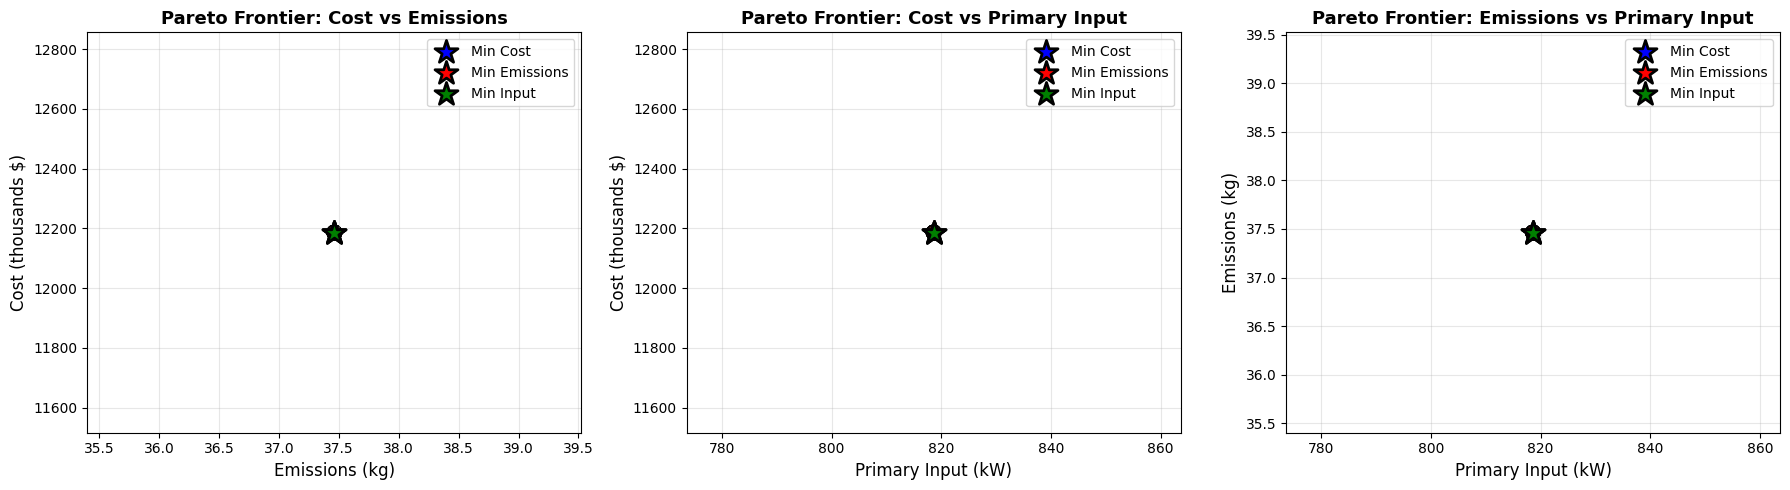


Pareto frontier visualization complete!


In [ ]:
# Create Pareto frontier plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Cost vs Emissions Pareto Frontier
ax1 = axes[0]
costs = pareto_df['Cost ($)'].values
emissions = pareto_df['Emissions (kg)'].values
colors_scatter = [colors_map.get(g, 'gray') for g in pareto_df['Generator'].values]

ax1.scatter(emissions, costs / 1000, c=colors_scatter, s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax1.plot(emissions, costs / 1000, 'k--', alpha=0.3, linewidth=1)

# Mark the three individual optimal points
ax1.scatter(obj_values['cost']['emissions'], obj_values['cost']['cost'] / 1000,
           marker='*', s=300, c='blue', edgecolors='black', linewidth=2, label='Min Cost', zorder=5)
ax1.scatter(obj_values['emissions']['emissions'], obj_values['emissions']['cost'] / 1000,
           marker='*', s=300, c='red', edgecolors='black', linewidth=2, label='Min Emissions', zorder=5)
ax1.scatter(obj_values['efficiency']['emissions'], obj_values['efficiency']['cost'] / 1000,
           marker='*', s=300, c='green', edgecolors='black', linewidth=2, label='Min Input', zorder=5)

ax1.set_xlabel('Emissions (kg)', fontsize=12)
ax1.set_ylabel('Cost (thousands $)', fontsize=12)
ax1.set_title('Pareto Frontier: Cost vs Emissions', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Cost vs Primary Input Pareto Frontier
ax2 = axes[1]
efficiency = pareto_df['Primary Input (kW)'].values

ax2.scatter(efficiency, costs / 1000, c=colors_scatter, s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax2.plot(efficiency, costs / 1000, 'k--', alpha=0.3, linewidth=1)

# Mark the three individual optimal points
ax2.scatter(obj_values['cost']['efficiency'], obj_values['cost']['cost'] / 1000,
           marker='*', s=300, c='blue', edgecolors='black', linewidth=2, label='Min Cost', zorder=5)
ax2.scatter(obj_values['emissions']['efficiency'], obj_values['emissions']['cost'] / 1000,
           marker='*', s=300, c='red', edgecolors='black', linewidth=2, label='Min Emissions', zorder=5)
ax2.scatter(obj_values['efficiency']['efficiency'], obj_values['efficiency']['cost'] / 1000,
           marker='*', s=300, c='green', edgecolors='black', linewidth=2, label='Min Input', zorder=5)

ax2.set_xlabel('Primary Input (kW)', fontsize=12)
ax2.set_ylabel('Cost (thousands $)', fontsize=12)
ax2.set_title('Pareto Frontier: Cost vs Primary Input', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)

# Plot 3: Emissions vs Primary Input
ax3 = axes[2]

ax3.scatter(efficiency, emissions, c=colors_scatter, s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax3.plot(efficiency, emissions, 'k--', alpha=0.3, linewidth=1)

# Mark the three individual optimal points
ax3.scatter(obj_values['cost']['efficiency'], obj_values['cost']['emissions'],
           marker='*', s=300, c='blue', edgecolors='black', linewidth=2, label='Min Cost', zorder=5)
ax3.scatter(obj_values['emissions']['efficiency'], obj_values['emissions']['emissions'],
           marker='*', s=300, c='red', edgecolors='black', linewidth=2, label='Min Emissions', zorder=5)
ax3.scatter(obj_values['efficiency']['efficiency'], obj_values['efficiency']['emissions'],
           marker='*', s=300, c='green', edgecolors='black', linewidth=2, label='Min Input', zorder=5)

ax3.set_xlabel('Primary Input (kW)', fontsize=12)
ax3.set_ylabel('Emissions (kg)', fontsize=12)
ax3.set_title('Pareto Frontier: Emissions vs Primary Input', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10, loc='best')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPareto frontier visualization complete!")